## SPACE-GM Tutorial

In this notebook, we'll follow the steps to run SPACE-GM on our dataset. The process contains the following steps:

1. Construct cellular graphs with raw inputs. These are te inputs we created after we processed the data and organized it into files organized by cores (regions). And each core has 3 files: for the cell coordinates, for the cell types, and the expressions of the cellls
2. Construct `CellularGraphDataset` and attach node-level / graph-level tasks
3. Initialize a Graph Neural Network (GNN) according to the prediction tasks
4. Train the GNN by randomly sampling subgraphs
5. Evaluate the GNN on node-level / graph-level tasks

In [2]:
import torch

!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

Found existing installation: torch-scatter 2.1.2
Uninstalling torch-scatter-2.1.2:
  Successfully uninstalled torch-scatter-2.1.2
Found existing installation: torch-cluster 1.6.3
Uninstalling torch-cluster-1.6.3:
  Successfully uninstalled torch-cluster-1.6.3
Looking in links: https://data.pyg.org/whl/torch-2.1.0.html
  Using cached torch_scatter-2.1.2-cp39-cp39-macosx_11_0_universal2.whl

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Looking in links: https://data.pyg.org/whl/torch-2.1.0.html
  Using cached torch_sparse-0.6.18-cp39-cp39-macosx_11_0_universal2.whl

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Looking in links: https://data.pyg.org/whl/torch-2.1.0.html
  Using cached torch_cluster-1.6.3-cp39-cp39-macosx_11_0_universal2.whl

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
  Clo

In [3]:
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch.nn as nn
import spacegm

------------
### Step 1: Construct Cellular Graphs

We first construct cellular graphs as `networkx.Graph` using raw inputs including cell coordinates, cell types, biomarker expression, etc.

Raw files are assumed to be sorted in regions, each region should contain a spatially-continuous area of tissue and has all cells in the area identified and segmented.

For each region, we need the following inputs:
- Cell coordinates stored in a csv file:
    - This file should contain at least two columns `X` and `Y` representing the 2D coordinates of cell centroids.
    - We highly recommend adding another column `CELL_ID` to match the rows with other raw inputs.
    - Example:
    | CELL_ID | X | Y |
    | --- | --- | --- |
    | 0 | 3 | 10 |
    | 1 | 25 | 12 |
    | 2 | 16 | 30 |
    | 3 | 32 | 26 |

- Cell types stored in a csv file:
    - This file should contain at least one column other than `CELL_ID`, in which case this column will be treated as the cell type column. Otherwise, please explicitly name the cell type column as `CELL_TYPE`.
    - Example:
    | CELL_ID | CELL_TYPE |
    | --- | --- |
    | 0 | CD4 T cell |
    | 1 | CD8 T cell |
    | 2 | Tumor cell |
    | 3 | B cell |

- Cell biomarker expression stored in a csv file:
    - This file should contain at least one column other than `CELL_ID`. All numeric columns in this file (other than `CELL_ID`) will be treated as biomarkers
    - Example (note that column `REGION_ID` will not be considered as a biomarker in this example):
    | CELL_ID | REGION_ID | BIOMARKER1 | BIOMARKER 2|
    | --- | --- | --- | --- |
    | 0 | region1 | 0.5 | 1.1 |
    | 1 | region1 | 0.8 | 2.3 |
    | 2 | region1 | 1.5 | 0.9 |
    | 3 | region1 | 5.5 | 0.1 |

- (Optional) Coordinates for the cell voronoi polygons:
    - Stored in a `json` or a `pickle` file. This file should contain a list of voronoi polygons enclosing cells.
    - Note that voronoi polygons can be calculated on-the-fly based on cell coordinates.
    - Example of content:
        ```text
        [array([[22.5, 22. ],
                [32.3, 17.1],
                [32.3, 12.5],
                [32.3, 0.  ],
                [18.8, 0.  ],
                [15.,  0.  ],
                [13.4, 17.5],
                [22.5, 22. ]]),
         array([[ 0. , 28.9],
                [ 0. , 30.3],
                [ 7.8, 30.3],
                [24.6, 30.3],
                [22.5, 22. ],
                [13.4, 17.5],
                [ 0. , 26.2],
                [ 0. , 28.9]]),
         array([[ 0. , 26.2],
                [13.4, 17.5],
                [15. ,  0. ],
                [12.3,  0. ],
                [ 0. ,  0. ],
                [ 0. , 18.8],
                [ 0. , 26.2]]),
         array([[24.6, 30.3],
                [28.2, 30.3],
                [32.3, 30.3],
                [32.3, 25.1],
                [32.3, 17.1],
                [22.5, 22. ],
                [24.6, 30.3]])]
        ```

Additionally, to train models for graph-level (region-level) tasks, a separate csv file is required to provide the labels:
- Labels for graph-level tasks:
    - The first column of this file must be `REGION_ID`: identifiers for regions in the dataset. This column will be used as the index for graph labels stored in `spacegm.inference.AddGraphLabel`.
    - The following columns store labels for graph-level tasks, with task names as column names.
    - Example:

    | REGION_ID | GRAPH_TASK1 | GRAPH_TASK 2|
    | --- | --- | --- |
    | region 1 | 0 | 1 |
    | region 2 | 0 | 0 |
    | region 3 | 1 | 1 |

<br/><br/><br/><br/>
Our data is found under `data_bodenmiller/basel_data`. As an example, lets see what the different kind of data look like for one of the regions. Lets also look at our graph level task.

In [23]:
from spacegm.graph_build import load_cell_coords, load_cell_types, load_cell_biomarker_expression, load_cell_features
parent_path = '../../data_bodenmiller/data_bodenmiller'
region_id = "BaselTMA_SP41_2_X2Y8"
cell_data_path = f"{parent_path}/basel_data/{region_id}"

cell_coords_file = f"{cell_data_path}_coords.csv"
cell_types_file = f"{cell_data_path}_cell_types.csv"
cell_biomarker_expression_file = f"{cell_data_path}_expression.csv"

graph_label_file = f"{parent_path}/../data_bodenmiller_label/basel_label.csv"

print("\nInputs for region %s:" % region_id)
print("\nCell coordinates")
display(load_cell_coords(cell_coords_file))
print("\nCell types")
display(load_cell_types(cell_types_file))
print("\nCell biomarker expression")
display(load_cell_biomarker_expression(cell_biomarker_expression_file))

print("\nGraph-level tasks")
display(pd.read_csv(graph_label_file, index_col=0))


Inputs for region BaselTMA_SP41_2_X2Y8:

Cell coordinates


,CELL_ID,X,Y
0,BaselTMA_SP41_2_X2Y8_1,34.814516,3.814516
1,BaselTMA_SP41_2_X2Y8_2,46.800000,2.842857
2,BaselTMA_SP41_2_X2Y8_3,55.608696,1.521739
3,BaselTMA_SP41_2_X2Y8_4,66.763158,2.250000
4,BaselTMA_SP41_2_X2Y8_5,179.736842,1.157895
...,...,...,...
2683,BaselTMA_SP41_2_X2Y8_2684,438.000000,767.085714
2684,BaselTMA_SP41_2_X2Y8_2685,447.068182,767.318182
2685,BaselTMA_SP41_2_X2Y8_2686,459.283019,767.245283
2686,BaselTMA_SP41_2_X2Y8_2687,532.046296,765.148148



Cell types


,CELL_ID,CELL_TYPE
0,BaselTMA_SP41_2_X2Y8_1,CK+ HR lo
1,BaselTMA_SP41_2_X2Y8_2,CK+ HR lo
2,BaselTMA_SP41_2_X2Y8_3,CK7+
3,BaselTMA_SP41_2_X2Y8_4,CK+ HR hi
4,BaselTMA_SP41_2_X2Y8_5,CK+ HR hi
...,...,...
2683,BaselTMA_SP41_2_X2Y8_2684,Endothelial
2684,BaselTMA_SP41_2_X2Y8_2685,Vimentin hi
2685,BaselTMA_SP41_2_X2Y8_2686,CK+ HR hi
2686,BaselTMA_SP41_2_X2Y8_2687,CK+ HR+



Cell biomarker expression


,CELL_ID,BM-1021522TM169DI EGFR,BM-117792DY163DI GATA3,BM-1261726IN113DI HISTONE,BM-1441101ER168DI KI67,BM-174864ND148DI SMA,BM-1921755SM149DI VIMENTI,BM-198883YB176DI CLEAVED,BM-201487EU151DI CERBB,BM-207736TB159DI P53,...,BM-6967GD160DI CD44,BM-71790DY162DI CD45,BM-77877ND146DI CD68,BM-8001752SM152DI CD3EPSI,BM-92964ER166DI CARBONI,BM-971099ND144DI CYTOKER,BM-98922YB174DI CYTOKER,BM-ND145DI TWIST,BM-PHOSPHO MTOR,BM-PHOSPHO S6
0,BaselTMA_SP41_2_X2Y8_1,0.246217,0.385657,4.620242,0.080534,0.099028,0.084540,1.016459,1.602201,0.036526,...,5.351835,0.073959,0.534661,0.000000,0.494848,0.617752,0.051974,0.406908,0.746158,0.427113
1,BaselTMA_SP41_2_X2Y8_10,0.355899,0.039103,7.203313,0.022683,0.328517,3.850891,0.451956,0.599551,0.037353,...,18.080585,0.035301,0.103042,0.010435,0.261704,0.035092,0.000000,0.107628,0.607560,0.917712
2,BaselTMA_SP41_2_X2Y8_100,0.332683,0.006803,8.653177,0.014743,0.426861,5.145165,0.451341,0.525175,0.021068,...,9.155012,0.091750,0.188676,0.035368,0.496233,0.082056,0.000000,0.186201,0.661436,0.406300
3,BaselTMA_SP41_2_X2Y8_1000,0.306576,0.125733,6.047886,0.090263,0.802009,1.513507,0.693687,1.421491,0.130187,...,21.663901,0.993787,0.228537,0.267576,0.457409,0.280291,0.049947,2.689871,0.769658,0.727629
4,BaselTMA_SP41_2_X2Y8_1001,0.570942,0.113852,7.813009,0.071429,3.664236,2.949356,0.598908,0.486456,0.038439,...,27.481128,0.441841,0.154712,0.200849,0.463762,0.075942,0.005442,0.199809,0.599025,0.166035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2683,BaselTMA_SP41_2_X2Y8_995,0.280632,0.210497,14.610496,1.237852,1.021958,2.538814,0.670556,1.065553,0.057685,...,46.179947,0.556959,0.425306,0.088456,0.305423,0.128076,0.010914,0.180192,0.590137,0.397986
2684,BaselTMA_SP41_2_X2Y8_996,0.137099,0.019373,6.780269,0.013373,0.712721,1.340226,0.212174,0.084320,0.068713,...,4.214022,0.060613,0.089423,0.000000,0.140792,0.032759,0.056099,0.134478,0.330909,0.249001
2685,BaselTMA_SP41_2_X2Y8_997,0.213335,0.077619,14.117228,0.000000,1.635555,2.895962,0.486355,0.208841,0.057055,...,14.611616,0.060583,0.119439,0.123482,0.351106,0.128571,0.040603,0.175851,0.762056,0.357209
2686,BaselTMA_SP41_2_X2Y8_998,0.464506,0.110801,14.123553,0.017057,3.209292,4.048957,0.917088,0.686612,0.056754,...,22.893760,0.308942,0.644189,0.061968,0.698867,0.084409,0.009892,0.506255,0.943329,1.737051



Graph-level tasks


,ERStatus,PRStatus,HER2Status,HR_status
REGION_ID,,,,
BaselTMA_SP41_257_X3Y1,1,0,0,ERposPRnegHER2neg
BaselTMA_SP41_7_X5Y1,1,1,0,ERposPRposHER2neg
BaselTMA_SP41_166_X15Y4,0,0,0,ERnegPRnegHER2neg
BaselTMA_SP41_238_X7Y1,1,1,0,ERposPRposHER2neg
BaselTMA_SP41_68_X9Y1,1,1,0,ERposPRposHER2neg
...,...,...,...,...
BaselTMA_SP43_225_X2Y9,1,1,0,ERposPRposHER2neg
BaselTMA_SP43_226_X6Y9,1,0,0,ERposPRnegHER2neg
BaselTMA_SP43_245_X6Y5,1,1,0,ERposPRposHER2neg


<br/><br/><br/><br/>

Now that we saw how the data looks like for one region, we can look at how a networkx graph can be constructed using the inputs above.

In [5]:
print("Constructing nx graph for region %s" % region_id)
G = spacegm.construct_graph_for_region(
    region_id,
    cell_coords_file=cell_coords_file,
    cell_types_file=cell_types_file,
    cell_biomarker_expression_file=cell_biomarker_expression_file)
print(G)

print("Information stored in a node:")
print(G.nodes[0])

Constructing nx graph for region BaselTMA_SP41_2_X2Y8
Graph with 2688 nodes and 7874 edges
Information stored in a node:
{'voronoi_polygon': array([[  6.21149299, 438.40814099],
       [ 11.81015654, 429.8764212 ],
       [  0.        , 430.25984413],
       [  0.        , 438.05513384],
       [  6.21149299, 438.40814099]]), 'cell_id': 'BaselTMA_SP41_2_X2Y8_1490', 'center_coord': (3.27586206896552, 434.655172413793), 'cell_type': 'Vimentin hi', 'biomarker_expression': {'1021522TM169DI EGFR': 0.442961620883715, '117792DY163DI GATA3': 0.42516219935329, '1261726IN113DI HISTONE': 19.293078485115, '1441101ER168DI KI67': 0.0, '174864ND148DI SMA': 1.61484886882217, '1921755SM149DI VIMENTI': 2.2936378789186, '198883YB176DI CLEAVED': 0.848307719924058, '201487EU151DI CERBB': 0.997474139897869, '207736TB159DI P53': 0.0686743879685349, '234832LU175DI PANCYTO': 11.0726238715818, '3111576ND143DI CYTOKER': 0.411880645111809, '312878GD158DI PROGEST': 0.898769946880269, '322787ND150DI CMYC': 0.162154

<br/><br/><br/><br/>
We saw how to create a networkx graph for a single region. And we have 283 regions in total. So now, we'll process all the regions and create graphs that represent them and store the nx graphs into a folder. When constructing the demo graph just for the one region above, we didn't use the voronoi coordinates, but going forward, we'll be using them for constructing all the graphs. And since we don't have the voronoi coordinates for the regions, we'll use a function to create them using the coordinates for each region.

In [26]:
def calcualte_voronoi_from_coords(x, y, region_id, xmax=None, ymax=None, xmin=None, ymin=None):
    """Calculate voronoi polygons from a set of points

    Points are assumed to have coordinates in ([0, xmax], [0, ymax])

    Args:
        x (array-like): x coordinates of points
        y (array-like): y coordinates of points
        xmax (float): maximum x coordinate
        ymax (float): maximum y coordinate
        (added by me to accomodate for the negative coordinates in the melanoma dataset)
        xmin (float): minimum x coordinate
        ymin (float): minimum y coordinate

    Returns:
        voronoi_polygons (list): list of voronoi polygons,
            represented by the coordinates of their exterior vertices
    """
    from geovoronoi import voronoi_regions_from_coords
    from shapely import geometry
    import json
    import os
    from pathlib import Path
    
    xmin = 1.01 * min(x) if xmin is None else xmin
    ymin = 1.01 * min(y) if ymin is None else ymin
    xmax = 1.01 * max(x) if xmax is None else xmax
    ymax = 1.01 * max(y) if ymax is None else ymax
    boundary = geometry.Polygon([[xmin, ymin], [xmax, ymin], [xmax, ymax], [xmin, ymax]])

    coords = np.stack([
        np.array(x).reshape((-1,)),
        np.array(y).reshape((-1,))], 1)
    region_polys, _ = voronoi_regions_from_coords(coords, boundary)
    voronoi_polygons = [list(map(list, region_polys[k].exterior.coords)) for k in region_polys]
    
    # Define the directory and filename
    # dir_path = Path(os.getcwd()).parent / 'parent_path'
    dir_path = f"{parent_path}/basel_data"
    file_path = f"{dir_path}/{region_id}.json"

    # Create the directory if it does not exist
    # os.makedirs(dir_path, exist_ok=True)

    # Write polygons to a JSON file
    with open(file_path, 'w') as f:
        json.dump(voronoi_polygons, f)
    
    return voronoi_polygons



Here, we are creating the voronoi polygons for each region and storing it into the folder with the rest of the data from each region

In [38]:
region_ids = []
files = os.listdir(parent_path + '/basel_data')
for i in files:
    if i.endswith('coords.csv'):
        tokens = i.split('_')
        region_ids.append('_'.join(tokens[:-1]))

#### This for loop should only be run once to create the voronoi polygons for each region
      
# for region_id in region_ids:
#     cell_coords_file = f"{parent_path}/basel_data/{region_id}_coords.csv"
#     cell_coords = load_cell_coords(cell_coords_file)
#     x = cell_coords['X']
#     y = cell_coords['Y']
#     voronoi_polygons_sp = calcualte_voronoi_from_coords(x, y, region_id)

In [33]:
raw_data_root = f"{parent_path}/basel_data"

dataset_root = f"{parent_path}/graph_and_model"
if not os.path.exists(dataset_root):
    os.makedirs(dataset_root)
    
nx_graph_root = os.path.join(dataset_root, "graph")
fig_save_root = os.path.join(dataset_root, "fig")
model_save_root = os.path.join(dataset_root, 'model')

os.makedirs(nx_graph_root, exist_ok=True)
os.makedirs(fig_save_root, exist_ok=True)
os.makedirs(model_save_root, exist_ok=True)

# Here are the names of some of the regions we have
region_ids[:5]

['BaselTMA_SP42_156_X15Y1',
 'BaselTMA_SP41_211_X4Y6',
 'BaselTMA_SP42_261_X11Y6',
 'BaselTMA_SP42_262_X10Y8',
 'BaselTMA_SP43_116_X3Y4']

In [48]:
path = f"{parent_path}/graph_and_model/graph"
len(os.listdir(path))

283

In [43]:
from tqdm import tqdm

for region_id in tqdm(region_ids):
    print("Processing %s" % region_id)
    cell_coords_file = os.path.join(raw_data_root, "%s_coords.csv" % region_id)
    cell_types_file = os.path.join(raw_data_root, "%s_cell_types.csv" % region_id)
    cell_biomarker_expression_file = os.path.join(raw_data_root, "%s_expression.csv" % region_id)
    # cell_features_file = os.path.join(raw_data_root, "%s.cell_features.csv" % region_id)
    voronoi_file = os.path.join(raw_data_root, "%s.json" % region_id)

    voronoi_polygon_img_output = os.path.join(fig_save_root, "%s_voronoi.png" % region_id)
    graph_img_output = os.path.join(fig_save_root, "%s_graph.png" % region_id)
    graph_output = os.path.join(nx_graph_root, "%s.gpkl" % region_id)

    if not os.path.exists(graph_output):
        G = spacegm.construct_graph_for_region(
            region_id,
            cell_coords_file=cell_coords_file,
            cell_types_file=cell_types_file,
            cell_biomarker_expression_file=cell_biomarker_expression_file,
            # cell_features_file=cell_features_file,
            voronoi_file=voronoi_file,
            graph_output=graph_output,
            voronoi_polygon_img_output=voronoi_polygon_img_output,
            graph_img_output=graph_img_output,
            figsize=10)

plt.close()
print("Finished!")

  0%|          | 0/283 [00:00<?, ?it/s]

Processing BaselTMA_SP42_156_X15Y1


  0%|          | 1/283 [00:01<08:15,  1.76s/it]

Processing BaselTMA_SP41_211_X4Y6


  1%|          | 2/283 [00:09<24:00,  5.13s/it]

Processing BaselTMA_SP42_261_X11Y6


  1%|          | 3/283 [00:18<33:34,  7.19s/it]

Processing BaselTMA_SP42_262_X10Y8


  1%|▏         | 4/283 [00:20<22:58,  4.94s/it]

Processing BaselTMA_SP43_116_X3Y4


  2%|▏         | 5/283 [00:40<48:15, 10.42s/it]

Processing BaselTMA_SP42_279_X14Y6


  2%|▏         | 6/283 [00:45<39:24,  8.54s/it]

Processing BaselTMA_SP41_42_X14Y5


  2%|▏         | 7/283 [00:50<33:30,  7.28s/it]

Processing BaselTMA_SP41_206_X1Y2


  3%|▎         | 8/283 [00:59<37:01,  8.08s/it]

Processing BaselTMA_SP42_51_X1Y2


  3%|▎         | 9/283 [01:05<32:52,  7.20s/it]

Processing BaselTMA_SP41_231_X6Y6_256


  4%|▎         | 10/283 [01:09<29:04,  6.39s/it]

Processing BaselTMA_SP41_38_X4Y7


  4%|▍         | 11/283 [01:16<29:44,  6.56s/it]

Processing BaselTMA_SP42_59_X3Y9


  4%|▍         | 12/283 [01:33<43:12,  9.57s/it]

Processing BaselTMA_SP41_63_X4Y9


  5%|▍         | 13/283 [01:43<43:37,  9.70s/it]

Processing BaselTMA_SP43_87_X15Y4


  5%|▍         | 14/283 [01:49<38:47,  8.65s/it]

Processing BaselTMA_SP41_214_X15Y6


  5%|▌         | 15/283 [01:55<34:53,  7.81s/it]

Processing BaselTMA_SP41_218_X9Y4_185


  6%|▌         | 16/283 [01:56<25:52,  5.82s/it]

Processing BaselTMA_SP41_72_X11Y1


  6%|▌         | 17/283 [02:05<29:46,  6.72s/it]

Processing BaselTMA_SP41_141_X11Y2


  6%|▋         | 18/283 [02:23<45:33, 10.31s/it]

Processing BaselTMA_SP43_94_X12Y7


  7%|▋         | 19/283 [02:32<43:15,  9.83s/it]

Processing BaselTMA_SP41_212_X1Y9


  7%|▋         | 20/283 [02:38<38:15,  8.73s/it]

Processing BaselTMA_SP41_196_X5Y7


  7%|▋         | 21/283 [02:42<32:13,  7.38s/it]

Processing BaselTMA_SP42_189_X5Y5


  8%|▊         | 22/283 [02:53<35:45,  8.22s/it]

Processing BaselTMA_SP43_78_X3Y9


  8%|▊         | 23/283 [03:06<41:37,  9.61s/it]

Processing BaselTMA_SP42_82_X2Y9


  8%|▊         | 24/283 [03:21<49:01, 11.36s/it]

Processing BaselTMA_SP42_151_X14Y7


  9%|▉         | 25/283 [03:33<49:15, 11.46s/it]

Processing BaselTMA_SP41_276_X9Y8


  9%|▉         | 26/283 [03:44<49:23, 11.53s/it]

Processing BaselTMA_SP41_112_X5Y8


 10%|▉         | 27/283 [03:53<45:46, 10.73s/it]

Processing BaselTMA_SP43_115_X4Y8


 10%|▉         | 28/283 [04:08<50:55, 11.98s/it]

Processing BaselTMA_SP41_257_X3Y1


 10%|█         | 29/283 [04:19<49:26, 11.68s/it]

Processing BaselTMA_SP42_158_X12Y6


 11%|█         | 30/283 [04:23<39:24,  9.35s/it]

Processing BaselTMA_SP42_184_X6Y8


 11%|█         | 31/283 [04:37<44:41, 10.64s/it]

Processing BaselTMA_SP43_225_X2Y9


 11%|█▏        | 32/283 [04:46<43:01, 10.28s/it]

Processing BaselTMA_SP43_180_X5Y2


 12%|█▏        | 33/283 [04:54<39:17,  9.43s/it]

Processing BaselTMA_SP43_168_X10Y5


 12%|█▏        | 34/283 [05:17<56:24, 13.59s/it]

Processing BaselTMA_SP41_284_X7Y2


 12%|█▏        | 35/283 [05:21<44:29, 10.77s/it]

Processing BaselTMA_SP43_47_X16Y4


 13%|█▎        | 36/283 [05:28<39:58,  9.71s/it]

Processing BaselTMA_SP43_111_X8Y6


 13%|█▎        | 37/283 [05:46<49:27, 12.06s/it]

Processing BaselTMA_SP41_41_X11Y8


 13%|█▎        | 38/283 [05:56<47:27, 11.62s/it]

Processing BaselTMA_SP42_27_X6Y6


 14%|█▍        | 39/283 [06:05<43:05, 10.60s/it]

Processing BaselTMA_SP42_127_X2Y8


 14%|█▍        | 40/283 [06:27<57:38, 14.23s/it]

Processing BaselTMA_SP42_99_X5Y7


 14%|█▍        | 41/283 [06:33<47:05, 11.68s/it]

Processing BaselTMA_SP42_10_X1Y5


 15%|█▍        | 42/283 [06:40<40:50, 10.17s/it]

Processing BaselTMA_SP41_86_X15Y3


 15%|█▌        | 43/283 [06:45<35:02,  8.76s/it]

Processing BaselTMA_SP43_199_X8Y5


 16%|█▌        | 44/283 [06:53<33:56,  8.52s/it]

Processing BaselTMA_SP42_74_X15Y3


 16%|█▌        | 45/283 [07:00<32:05,  8.09s/it]

Processing BaselTMA_SP41_159_X11Y4


 16%|█▋        | 46/283 [07:02<24:19,  6.16s/it]

Processing BaselTMA_SP43_201_X14Y5


 17%|█▋        | 47/283 [07:10<26:44,  6.80s/it]

Processing BaselTMA_SP41_203_X8Y8


 17%|█▋        | 48/283 [07:18<27:40,  7.07s/it]

Processing BaselTMA_SP41_191_X15Y7


 17%|█▋        | 49/283 [07:31<34:38,  8.88s/it]

Processing BaselTMA_SP42_273_X6Y7


 18%|█▊        | 50/283 [07:39<33:26,  8.61s/it]

Processing BaselTMA_SP41_165_X5Y6


 18%|█▊        | 51/283 [07:45<29:56,  7.74s/it]

Processing BaselTMA_SP42_91_X11Y3


 18%|█▊        | 52/283 [07:58<36:03,  9.37s/it]

Processing BaselTMA_SP42_12_X12Y8


 19%|█▊        | 53/283 [08:01<28:42,  7.49s/it]

Processing BaselTMA_SP42_154_X7Y4


 19%|█▉        | 54/283 [08:05<24:43,  6.48s/it]

Processing BaselTMA_SP43_222_X7Y2


 19%|█▉        | 55/283 [08:15<28:56,  7.62s/it]

Processing BaselTMA_SP43_17_X11Y4


 20%|█▉        | 56/283 [08:27<33:52,  8.95s/it]

Processing BaselTMA_SP42_123_X8Y6


 20%|██        | 57/283 [08:29<25:18,  6.72s/it]

Processing BaselTMA_SP41_40_X16Y7


 20%|██        | 58/283 [08:37<26:41,  7.12s/it]

Processing BaselTMA_SP41_133_X3Y6


 21%|██        | 59/283 [08:49<32:25,  8.68s/it]

Processing BaselTMA_SP41_274_X13Y1


 21%|██        | 60/283 [08:53<26:13,  7.06s/it]

Processing BaselTMA_SP42_145_X1Y4


 22%|██▏       | 61/283 [09:02<28:38,  7.74s/it]

Processing BaselTMA_SP43_132_X13Y1


 22%|██▏       | 62/283 [09:14<33:53,  9.20s/it]

Processing BaselTMA_SP43_150_X5Y3


 22%|██▏       | 63/283 [09:21<30:40,  8.37s/it]

Processing BaselTMA_SP43_102_X1Y4


 23%|██▎       | 64/283 [09:37<38:29, 10.55s/it]

Processing BaselTMA_SP43_149_X10Y6_223


 23%|██▎       | 65/283 [09:38<28:42,  7.90s/it]

Processing BaselTMA_SP43_194_X11Y7


 23%|██▎       | 66/283 [09:43<24:54,  6.89s/it]

Processing BaselTMA_SP42_251_X15Y2


 24%|██▎       | 67/283 [09:48<22:29,  6.25s/it]

Processing BaselTMA_SP42_16_X3Y4


 24%|██▍       | 68/283 [09:49<17:20,  4.84s/it]

Processing BaselTMA_SP42_183_X3Y6


 24%|██▍       | 69/283 [09:55<18:42,  5.25s/it]

Processing BaselTMA_SP43_19_X15Y2


 25%|██▍       | 70/283 [10:06<24:21,  6.86s/it]

Processing BaselTMA_SP41_57_X8Y6


 25%|██▌       | 71/283 [10:10<21:24,  6.06s/it]

Processing BaselTMA_SP43_95_X13Y2


 25%|██▌       | 72/283 [10:17<22:37,  6.43s/it]

Processing BaselTMA_SP43_226_X6Y9


 26%|██▌       | 73/283 [10:34<33:06,  9.46s/it]

Processing BaselTMA_SP42_176_X3Y7


 26%|██▌       | 74/283 [10:48<37:57, 10.90s/it]

Processing BaselTMA_SP41_267_X13Y8


 27%|██▋       | 75/283 [10:54<32:04,  9.25s/it]

Processing BaselTMA_SP41_220_X10Y5


 27%|██▋       | 76/283 [11:04<32:55,  9.54s/it]

Processing BaselTMA_SP43_200_X9Y6


 27%|██▋       | 77/283 [11:11<29:55,  8.71s/it]

Processing BaselTMA_SP42_71_X8Y8


 28%|██▊       | 78/283 [11:16<26:22,  7.72s/it]

Processing BaselTMA_SP42_185_X7Y5


 28%|██▊       | 79/283 [11:23<25:18,  7.45s/it]

Processing BaselTMA_SP42_182_X1Y8


 28%|██▊       | 80/283 [11:30<25:03,  7.41s/it]

Processing BaselTMA_SP42_152_X15Y6


 29%|██▊       | 81/283 [11:37<24:21,  7.23s/it]

Processing BaselTMA_SP41_48_X14Y8


 29%|██▉       | 82/283 [11:48<27:40,  8.26s/it]

Processing BaselTMA_SP42_169_X3Y8


 29%|██▉       | 83/283 [11:58<29:10,  8.75s/it]

Processing BaselTMA_SP43_221_X2Y7


 30%|██▉       | 84/283 [12:02<24:20,  7.34s/it]

Processing BaselTMA_SP41_55_X10Y7


 30%|███       | 85/283 [12:06<21:47,  6.60s/it]

Processing BaselTMA_SP41_114_X13Y4


 30%|███       | 86/283 [12:14<22:18,  6.79s/it]

Processing BaselTMA_SP42_275_X5Y4


 31%|███       | 87/283 [12:19<20:50,  6.38s/it]

Processing BaselTMA_SP42_190_X9Y5


 31%|███       | 88/283 [12:25<20:33,  6.32s/it]

Processing BaselTMA_SP43_23_X15Y7


 31%|███▏      | 89/283 [12:33<21:50,  6.75s/it]

Processing BaselTMA_SP43_50_X7Y1


 32%|███▏      | 90/283 [12:43<24:22,  7.58s/it]

Processing BaselTMA_SP42_162_X16Y7


 32%|███▏      | 91/283 [12:52<25:39,  8.02s/it]

Processing BaselTMA_SP41_18_X13Y5


 33%|███▎      | 92/283 [12:57<22:46,  7.16s/it]

Processing BaselTMA_SP41_237_X16Y6


 33%|███▎      | 93/283 [13:04<23:05,  7.29s/it]

Processing BaselTMA_SP42_138_X3Y5


 33%|███▎      | 94/283 [13:15<26:19,  8.36s/it]

Processing BaselTMA_SP41_9_X6Y9


 34%|███▎      | 95/283 [13:23<25:16,  8.07s/it]

Processing BaselTMA_SP43_75_X2Y5


 34%|███▍      | 96/283 [13:30<24:42,  7.93s/it]

Processing BaselTMA_SP42_13_X5Y8


 34%|███▍      | 97/283 [13:39<25:43,  8.30s/it]

Processing BaselTMA_SP42_174_X9Y6


 35%|███▍      | 98/283 [13:50<27:59,  9.08s/it]

Processing BaselTMA_SP42_175_X15Y5_235


 35%|███▍      | 99/283 [13:56<24:57,  8.14s/it]

Processing BaselTMA_SP42_171_X2Y7


 35%|███▌      | 100/283 [14:07<27:33,  9.03s/it]

Processing BaselTMA_SP43_65_X14Y6


 36%|███▌      | 101/283 [14:09<20:19,  6.70s/it]

Processing BaselTMA_SP42_73_X12Y7


 36%|███▌      | 102/283 [14:17<21:57,  7.28s/it]

Processing BaselTMA_SP43_243_X13Y3


 36%|███▋      | 103/283 [14:23<20:08,  6.72s/it]

Processing BaselTMA_SP42_64_X13Y4


 37%|███▋      | 104/283 [14:35<24:52,  8.34s/it]

Processing BaselTMA_SP41_126_X14Y7


 37%|███▋      | 105/283 [14:43<24:39,  8.31s/it]

Processing BaselTMA_SP41_104_X7Y4


 37%|███▋      | 106/283 [14:45<19:00,  6.45s/it]

Processing BaselTMA_SP41_62_X7Y7


 38%|███▊      | 107/283 [14:53<20:29,  6.99s/it]

Processing BaselTMA_SP42_236_X11Y7


 38%|███▊      | 108/283 [15:01<20:48,  7.14s/it]

Processing BaselTMA_SP41_101_X10Y8


 39%|███▊      | 109/283 [15:11<23:02,  7.95s/it]

Processing BaselTMA_SP42_98_X11Y5


 39%|███▉      | 110/283 [15:18<22:04,  7.66s/it]

Processing BaselTMA_SP43_202_X9Y5


 39%|███▉      | 111/283 [15:26<22:34,  7.88s/it]

Processing BaselTMA_SP42_130_X1Y6


 40%|███▉      | 112/283 [15:32<21:10,  7.43s/it]

Processing BaselTMA_SP41_239_X11Y3_151


 40%|███▉      | 113/283 [15:33<15:15,  5.39s/it]

Processing BaselTMA_SP43_278_X3Y2


 40%|████      | 114/283 [15:43<18:51,  6.69s/it]

Processing BaselTMA_SP42_148_X5Y6


 41%|████      | 115/283 [15:51<19:39,  7.02s/it]

Processing BaselTMA_SP41_106_X2Y9


 41%|████      | 116/283 [15:57<19:16,  6.93s/it]

Processing BaselTMA_SP42_56_X2Y6


 41%|████▏     | 117/283 [16:06<20:29,  7.41s/it]

Processing BaselTMA_SP43_281_X8Y7


 42%|████▏     | 118/283 [16:12<19:41,  7.16s/it]

Processing BaselTMA_SP41_283_X2Y6


 42%|████▏     | 119/283 [16:19<19:31,  7.14s/it]

Processing BaselTMA_SP41_228_X7Y3


 42%|████▏     | 120/283 [16:22<15:24,  5.67s/it]

Processing BaselTMA_SP42_81_X11Y4


 43%|████▎     | 121/283 [16:31<18:26,  6.83s/it]

Processing BaselTMA_SP41_238_X7Y1


 43%|████▎     | 122/283 [16:40<20:14,  7.54s/it]

Processing BaselTMA_SP43_110_X14Y8


 43%|████▎     | 123/283 [16:45<17:31,  6.57s/it]

Processing BaselTMA_SP43_67_X14Y7


 44%|████▍     | 124/283 [16:55<20:30,  7.74s/it]

Processing BaselTMA_SP42_285_X7Y7


 44%|████▍     | 125/283 [17:07<23:41,  9.00s/it]

Processing BaselTMA_SP42_120_X5Y2


 45%|████▍     | 126/283 [17:19<25:53,  9.90s/it]

Processing BaselTMA_SP42_113_X2Y5


 45%|████▍     | 127/283 [17:29<25:23,  9.76s/it]

Processing BaselTMA_SP43_128_X16Y7


 45%|████▌     | 128/283 [17:46<31:15, 12.10s/it]

Processing BaselTMA_SP42_6_X11Y1


 46%|████▌     | 129/283 [17:52<26:26, 10.30s/it]

Processing BaselTMA_SP43_246_X2Y6


 46%|████▌     | 130/283 [17:58<23:06,  9.06s/it]

Processing BaselTMA_SP43_3_X13Y6


 46%|████▋     | 131/283 [18:03<19:45,  7.80s/it]

Processing BaselTMA_SP41_60_X11Y7


 47%|████▋     | 132/283 [18:11<19:19,  7.68s/it]

Processing BaselTMA_SP41_88_X11Y5_242


 47%|████▋     | 133/283 [18:15<16:21,  6.54s/it]

Processing BaselTMA_SP41_280_X9Y5


 47%|████▋     | 134/283 [18:23<17:52,  7.20s/it]

Processing BaselTMA_SP41_37_X7Y6


 48%|████▊     | 135/283 [18:32<18:33,  7.52s/it]

Processing BaselTMA_SP43_260_X10Y4


 48%|████▊     | 136/283 [18:40<19:09,  7.82s/it]

Processing BaselTMA_SP42_264_X14Y5


 48%|████▊     | 137/283 [18:48<19:08,  7.87s/it]

Processing BaselTMA_SP42_160_X13Y5


 49%|████▉     | 138/283 [18:57<20:01,  8.29s/it]

Processing BaselTMA_SP41_44_X2Y7


 49%|████▉     | 139/283 [19:07<20:48,  8.67s/it]

Processing BaselTMA_SP43_4_X15Y3


 49%|████▉     | 140/283 [19:16<21:13,  8.91s/it]

Processing BaselTMA_SP42_167_X14Y8


 50%|████▉     | 141/283 [19:18<15:59,  6.75s/it]

Processing BaselTMA_SP41_224_X3Y7


 50%|█████     | 142/283 [19:23<14:49,  6.31s/it]

Processing BaselTMA_SP43_170_X3Y3


 51%|█████     | 143/283 [19:29<14:20,  6.15s/it]

Processing BaselTMA_SP42_84_X7Y1


 51%|█████     | 144/283 [19:33<12:35,  5.44s/it]

Processing BaselTMA_SP41_39_X1Y7


 51%|█████     | 145/283 [19:40<13:44,  5.98s/it]

Processing BaselTMA_SP43_248_X8Y8


 52%|█████▏    | 146/283 [19:44<11:52,  5.20s/it]

Processing BaselTMA_SP42_155_X4Y9


 52%|█████▏    | 147/283 [19:58<17:54,  7.90s/it]

Processing BaselTMA_SP43_15_X1Y9


 52%|█████▏    | 148/283 [20:11<21:27,  9.54s/it]

Processing BaselTMA_SP43_108_X13Y8


 53%|█████▎    | 149/283 [20:32<29:01, 13.00s/it]

Processing BaselTMA_SP42_253_X13Y2


 53%|█████▎    | 150/283 [20:42<26:36, 12.00s/it]

Processing BaselTMA_SP43_271_X11Y8


 53%|█████▎    | 151/283 [20:50<23:43, 10.78s/it]

Processing BaselTMA_SP41_263_X1Y4


 54%|█████▎    | 152/283 [20:52<17:59,  8.24s/it]

Processing BaselTMA_SP41_239_X11Y3_165


 54%|█████▍    | 153/283 [21:00<17:39,  8.15s/it]

Processing BaselTMA_SP41_11_X13Y7


 54%|█████▍    | 154/283 [21:15<22:01, 10.25s/it]

Processing BaselTMA_SP43_272_X11Y3


 55%|█████▍    | 155/283 [21:21<18:46,  8.80s/it]

Processing BaselTMA_SP42_146_X16Y6


 55%|█████▌    | 156/283 [21:22<13:58,  6.61s/it]

Processing BaselTMA_SP42_80_X3Y3


 55%|█████▌    | 157/283 [21:35<17:49,  8.49s/it]

Processing BaselTMA_SP42_208_X15Y7


 56%|█████▌    | 158/283 [21:40<15:42,  7.54s/it]

Processing BaselTMA_SP43_103_X5Y4


 56%|█████▌    | 159/283 [21:52<18:17,  8.85s/it]

Processing BaselTMA_SP43_1_X1Y8


 57%|█████▋    | 160/283 [22:00<17:34,  8.57s/it]

Processing BaselTMA_SP43_32_X4Y6


 57%|█████▋    | 161/283 [22:12<19:39,  9.67s/it]

Processing BaselTMA_SP41_255_X12Y8


 57%|█████▋    | 162/283 [22:18<16:47,  8.33s/it]

Processing BaselTMA_SP42_210_X4Y5


 58%|█████▊    | 163/283 [22:24<15:39,  7.83s/it]

Processing BaselTMA_SP43_172_X9Y2


 58%|█████▊    | 164/283 [22:33<15:58,  8.05s/it]

Processing BaselTMA_SP42_70_X5Y3


 58%|█████▊    | 165/283 [22:42<16:14,  8.26s/it]

Processing BaselTMA_SP42_217_X1Y3


 59%|█████▊    | 166/283 [22:52<17:40,  9.06s/it]

Processing BaselTMA_SP41_204_X16Y4_238


 59%|█████▉    | 167/283 [22:54<13:26,  6.95s/it]

Processing BaselTMA_SP42_25_X3Y2


 59%|█████▉    | 168/283 [23:05<15:35,  8.13s/it]

Processing BaselTMA_SP43_250_X1Y3


 60%|█████▉    | 169/283 [23:12<14:47,  7.78s/it]

Processing BaselTMA_SP41_14_X1Y8


 60%|██████    | 170/283 [23:22<15:59,  8.49s/it]

Processing BaselTMA_SP43_233_X13Y7


 60%|██████    | 171/283 [23:28<14:23,  7.71s/it]

Processing BaselTMA_SP43_241_X7Y3


 61%|██████    | 172/283 [23:37<14:51,  8.03s/it]

Processing BaselTMA_SP43_149_X10Y6_222


 61%|██████    | 173/283 [23:39<11:13,  6.12s/it]

Processing BaselTMA_SP43_21_X3Y5


 61%|██████▏   | 174/283 [23:44<10:27,  5.75s/it]

Processing BaselTMA_SP43_209_X11Y1


 62%|██████▏   | 175/283 [23:49<10:15,  5.70s/it]

Processing BaselTMA_SP41_53_X6Y8


 62%|██████▏   | 176/283 [23:55<10:26,  5.85s/it]

Processing BaselTMA_SP41_45_X3Y3


 63%|██████▎   | 177/283 [24:04<11:52,  6.72s/it]

Processing BaselTMA_SP41_129_X7Y8


 63%|██████▎   | 178/283 [24:09<10:54,  6.23s/it]

Processing BaselTMA_SP41_92_X12Y7


 63%|██████▎   | 179/283 [24:23<14:34,  8.41s/it]

Processing BaselTMA_SP42_109_X10Y6


 64%|██████▎   | 180/283 [24:30<13:59,  8.15s/it]

Processing BaselTMA_SP42_46_X10Y7


 64%|██████▍   | 181/283 [24:39<14:05,  8.29s/it]

Processing BaselTMA_SP43_193_X9Y7


 64%|██████▍   | 182/283 [24:50<15:10,  9.01s/it]

Processing BaselTMA_SP43_79_X7Y4


 65%|██████▍   | 183/283 [25:01<16:12,  9.73s/it]

Processing BaselTMA_SP42_105_X9Y1


 65%|██████▌   | 184/283 [25:04<12:26,  7.54s/it]

Processing BaselTMA_SP43_77_X3Y8


 65%|██████▌   | 185/283 [25:11<12:09,  7.44s/it]

Processing BaselTMA_SP42_28_X11Y2


 66%|██████▌   | 186/283 [25:20<12:44,  7.88s/it]

Processing BaselTMA_SP42_192_X8Y5


 66%|██████▌   | 187/283 [25:29<13:06,  8.19s/it]

Processing BaselTMA_SP42_229_X1Y7


 66%|██████▋   | 188/283 [25:38<13:21,  8.44s/it]

Processing BaselTMA_SP41_52_X9Y3


 67%|██████▋   | 189/283 [25:47<13:27,  8.59s/it]

Processing BaselTMA_SP41_177_X16Y5


 67%|██████▋   | 190/283 [25:55<13:13,  8.53s/it]

Processing BaselTMA_SP43_97_X16Y6


 67%|██████▋   | 191/283 [26:06<14:25,  9.41s/it]

Processing BaselTMA_SP41_166_X15Y4


 68%|██████▊   | 192/283 [26:16<14:10,  9.35s/it]

Processing BaselTMA_SP42_76_X13Y6


 68%|██████▊   | 193/283 [26:24<13:33,  9.03s/it]

Processing BaselTMA_SP43_269_X5Y9


 69%|██████▊   | 194/283 [26:36<14:46,  9.97s/it]

Processing BaselTMA_SP43_66_X15Y6


 69%|██████▉   | 195/283 [26:41<12:29,  8.51s/it]

Processing BaselTMA_SP41_153_X7Y5


 69%|██████▉   | 196/283 [26:45<10:31,  7.26s/it]

Processing BaselTMA_SP41_2_X2Y8


 70%|██████▉   | 197/283 [26:54<10:59,  7.67s/it]

Processing BaselTMA_SP41_277_X12Y6


 70%|██████▉   | 198/283 [26:56<08:27,  5.97s/it]

Processing BaselTMA_SP43_197_X4Y9


 70%|███████   | 199/283 [26:59<07:00,  5.01s/it]

Processing BaselTMA_SP41_234_X10Y6


 71%|███████   | 200/283 [27:06<07:46,  5.62s/it]

Processing BaselTMA_SP41_186_X5Y4


 71%|███████   | 201/283 [27:22<11:53,  8.70s/it]

Processing BaselTMA_SP43_213_X7Y7


 71%|███████▏  | 202/283 [27:28<10:36,  7.86s/it]

Processing BaselTMA_SP42_54_X12Y5


 72%|███████▏  | 203/283 [27:38<11:22,  8.53s/it]

Processing BaselTMA_SP42_175_X15Y5_236


 72%|███████▏  | 204/283 [27:40<08:44,  6.64s/it]

Processing BaselTMA_SP43_125_X5Y7


 72%|███████▏  | 205/283 [27:46<08:26,  6.49s/it]

Processing BaselTMA_SP43_122_X12Y8


 73%|███████▎  | 206/283 [27:56<09:41,  7.55s/it]

Processing BaselTMA_SP43_85_X9Y1


 73%|███████▎  | 207/283 [28:02<08:43,  6.89s/it]

Processing BaselTMA_SP43_26_X16Y5


 73%|███████▎  | 208/283 [28:06<07:53,  6.31s/it]

Processing BaselTMA_SP43_118_X13Y5


 74%|███████▍  | 209/283 [28:16<09:02,  7.34s/it]

Processing BaselTMA_SP43_143_X1Y2


 74%|███████▍  | 210/283 [28:18<06:42,  5.52s/it]

Processing BaselTMA_SP42_36_X5Y1


 75%|███████▍  | 211/283 [28:24<07:06,  5.92s/it]

Processing BaselTMA_SP43_147_X6Y6


 75%|███████▍  | 212/283 [28:26<05:26,  4.60s/it]

Processing BaselTMA_SP42_179_X13Y8


 75%|███████▌  | 213/283 [28:42<09:22,  8.04s/it]

Processing BaselTMA_SP41_7_X5Y1


 76%|███████▌  | 214/283 [28:53<10:24,  9.05s/it]

Processing BaselTMA_SP43_252_X6Y7


 76%|███████▌  | 215/283 [29:01<09:45,  8.62s/it]

Processing BaselTMA_SP41_20_X12Y5


 76%|███████▋  | 216/283 [29:03<07:17,  6.53s/it]

Processing BaselTMA_SP42_258_X4Y7


 77%|███████▋  | 217/283 [29:08<06:44,  6.13s/it]

Processing BaselTMA_SP41_58_X15Y1


 77%|███████▋  | 218/283 [29:21<08:54,  8.22s/it]

Processing BaselTMA_SP43_137_X10Y3


 77%|███████▋  | 219/283 [29:23<06:40,  6.25s/it]

Processing BaselTMA_SP43_107_X4Y7


 78%|███████▊  | 220/283 [29:31<07:23,  7.05s/it]

Processing BaselTMA_SP43_270_X6Y8


 78%|███████▊  | 221/283 [29:44<09:03,  8.76s/it]

Processing BaselTMA_SP42_5_X8Y7


 78%|███████▊  | 222/283 [29:51<08:22,  8.24s/it]

Processing BaselTMA_SP41_204_X16Y4_237


 79%|███████▉  | 223/283 [29:54<06:34,  6.57s/it]

Processing BaselTMA_SP43_205_X3Y6


 79%|███████▉  | 224/283 [30:01<06:28,  6.59s/it]

Processing BaselTMA_SP43_173_X2Y8


 80%|███████▉  | 225/283 [30:19<09:48, 10.14s/it]

Processing BaselTMA_SP43_90_X7Y6


 80%|███████▉  | 226/283 [30:29<09:42, 10.23s/it]

Processing BaselTMA_SP41_218_X9Y4_240


 80%|████████  | 227/283 [30:37<08:44,  9.37s/it]

Processing BaselTMA_SP42_198_X7Y8


 81%|████████  | 228/283 [30:44<08:03,  8.79s/it]

Processing BaselTMA_SP43_34_X12Y5


 81%|████████  | 229/283 [30:51<07:27,  8.29s/it]

Processing BaselTMA_SP43_119_X9Y8


 81%|████████▏ | 230/283 [30:56<06:21,  7.20s/it]

Processing BaselTMA_SP43_131_X13Y4


 82%|████████▏ | 231/283 [31:01<05:35,  6.45s/it]

Processing BaselTMA_SP42_178_X13Y7


 82%|████████▏ | 232/283 [31:07<05:24,  6.37s/it]

Processing BaselTMA_SP41_135_X8Y5


 82%|████████▏ | 233/283 [31:17<06:18,  7.57s/it]

Processing BaselTMA_SP41_31_X15Y2


 83%|████████▎ | 234/283 [31:31<07:35,  9.29s/it]

Processing BaselTMA_SP41_83_X13Y2


 83%|████████▎ | 235/283 [31:44<08:29, 10.61s/it]

Processing BaselTMA_SP41_61_X3Y4


 83%|████████▎ | 236/283 [31:50<07:11,  9.19s/it]

Processing BaselTMA_SP41_219_X8Y7


 84%|████████▎ | 237/283 [31:58<06:45,  8.81s/it]

Processing BaselTMA_SP42_188_X10Y5


 84%|████████▍ | 238/283 [32:03<05:40,  7.57s/it]

Processing BaselTMA_SP43_43_X5Y5


 84%|████████▍ | 239/283 [32:09<05:17,  7.21s/it]

Processing BaselTMA_SP41_256_X9Y7


 85%|████████▍ | 240/283 [32:18<05:33,  7.74s/it]

Processing BaselTMA_SP42_223_X9Y7


 85%|████████▌ | 241/283 [32:26<05:22,  7.68s/it]

Processing BaselTMA_SP41_216_X1Y6


 86%|████████▌ | 242/283 [32:32<05:03,  7.41s/it]

Processing BaselTMA_SP41_68_X9Y1


 86%|████████▌ | 243/283 [32:39<04:47,  7.19s/it]

Processing BaselTMA_SP41_100_X15Y5


 86%|████████▌ | 244/283 [32:50<05:19,  8.19s/it]

Processing BaselTMA_SP42_164_X9Y8


 87%|████████▋ | 245/283 [32:55<04:36,  7.28s/it]

Processing BaselTMA_SP41_159_X12Y4


 87%|████████▋ | 246/283 [33:02<04:27,  7.23s/it]

Processing BaselTMA_SP42_232_X7Y6


 87%|████████▋ | 247/283 [33:09<04:17,  7.16s/it]

Processing BaselTMA_SP42_29_X7Y2


 88%|████████▊ | 248/283 [33:12<03:29,  5.99s/it]

Processing BaselTMA_SP42_35_X16Y4


 88%|████████▊ | 249/283 [33:17<03:11,  5.62s/it]

Processing BaselTMA_SP41_231_X6Y6_10


 88%|████████▊ | 250/283 [33:19<02:33,  4.66s/it]

Processing BaselTMA_SP43_242_X5Y6


 89%|████████▊ | 251/283 [33:28<03:05,  5.80s/it]

Processing BaselTMA_SP41_117_X13Y3


 89%|████████▉ | 252/283 [33:41<04:13,  8.18s/it]

Processing BaselTMA_SP42_240_X9Y2


 89%|████████▉ | 253/283 [33:49<03:56,  7.89s/it]

Processing BaselTMA_SP43_230_X11Y5


 90%|████████▉ | 254/283 [33:56<03:43,  7.70s/it]

Processing BaselTMA_SP43_207_X1Y6


 90%|█████████ | 255/283 [34:05<03:47,  8.12s/it]

Processing BaselTMA_SP42_163_X1Y9


 90%|█████████ | 256/283 [34:13<03:37,  8.07s/it]

Processing BaselTMA_SP42_89_X4Y6


 91%|█████████ | 257/283 [34:21<03:29,  8.04s/it]

Processing BaselTMA_SP42_161_X13Y3


 91%|█████████ | 258/283 [34:33<03:47,  9.10s/it]

Processing BaselTMA_SP41_268_X6Y7


 92%|█████████▏| 259/283 [34:40<03:23,  8.47s/it]

Processing BaselTMA_SP43_144_X15Y1


 92%|█████████▏| 260/283 [35:00<04:35, 11.99s/it]

Processing BaselTMA_SP43_244_X3Y1


 92%|█████████▏| 261/283 [35:09<04:02, 11.02s/it]

Processing BaselTMA_SP41_254_X11Y6


 93%|█████████▎| 262/283 [35:17<03:37, 10.38s/it]

Processing BaselTMA_SP43_140_X10Y7


 93%|█████████▎| 263/283 [35:23<02:59,  8.98s/it]

Processing BaselTMA_SP43_235_X11Y2


 93%|█████████▎| 264/283 [35:33<02:57,  9.35s/it]

Processing BaselTMA_SP42_136_X9Y4


 94%|█████████▎| 265/283 [35:43<02:47,  9.30s/it]

Processing BaselTMA_SP41_24_X5Y2


 94%|█████████▍| 266/283 [35:49<02:24,  8.51s/it]

Processing BaselTMA_SP41_227_X9Y6


 94%|█████████▍| 267/283 [35:54<01:58,  7.44s/it]

Processing BaselTMA_SP42_215_X3Y1


 95%|█████████▍| 268/283 [36:01<01:50,  7.36s/it]

Processing BaselTMA_SP41_134_X3Y8


 95%|█████████▌| 269/283 [36:08<01:39,  7.11s/it]

Processing BaselTMA_SP42_121_X11Y8


 95%|█████████▌| 270/283 [36:15<01:32,  7.13s/it]

Processing BaselTMA_SP41_88_X11Y5_235


 96%|█████████▌| 271/283 [36:29<01:51,  9.27s/it]

Processing BaselTMA_SP41_282_X1Y3


 96%|█████████▌| 272/283 [36:37<01:35,  8.68s/it]

Processing BaselTMA_SP41_33_X14Y6


 96%|█████████▋| 273/283 [36:47<01:32,  9.21s/it]

Processing BaselTMA_SP43_266_X7Y8


 97%|█████████▋| 274/283 [36:58<01:27,  9.75s/it]

Processing BaselTMA_SP41_247_X13Y6


 97%|█████████▋| 275/283 [37:09<01:20, 10.03s/it]

Processing BaselTMA_SP43_142_X5Y1


 98%|█████████▊| 276/283 [37:16<01:03,  9.13s/it]

Processing BaselTMA_SP41_8_X5Y9


 98%|█████████▊| 277/283 [37:22<00:48,  8.12s/it]

Processing BaselTMA_SP43_157_X4Y5


 98%|█████████▊| 278/283 [37:24<00:32,  6.52s/it]

Processing BaselTMA_SP43_124_X10Y8


 99%|█████████▊| 279/283 [37:26<00:19,  4.95s/it]

Processing BaselTMA_SP43_245_X6Y5


 99%|█████████▉| 280/283 [37:39<00:22,  7.59s/it]

Processing BaselTMA_SP43_49_X1Y5


 99%|█████████▉| 281/283 [37:52<00:18,  9.03s/it]

Processing BaselTMA_SP42_96_X9Y3


100%|█████████▉| 282/283 [37:56<00:07,  7.54s/it]

Processing BaselTMA_SP42_181_X6Y5


100%|██████████| 283/283 [38:01<00:00,  8.06s/it]


Finished!


<Figure size 640x480 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<br/><br/><br/><br/>

The function `spacegm.construct_graph_for_region` also generates some visualizations for each region, stored under `graph_img_output` and `voronoi_polygon_img_output`.

Here is an example:

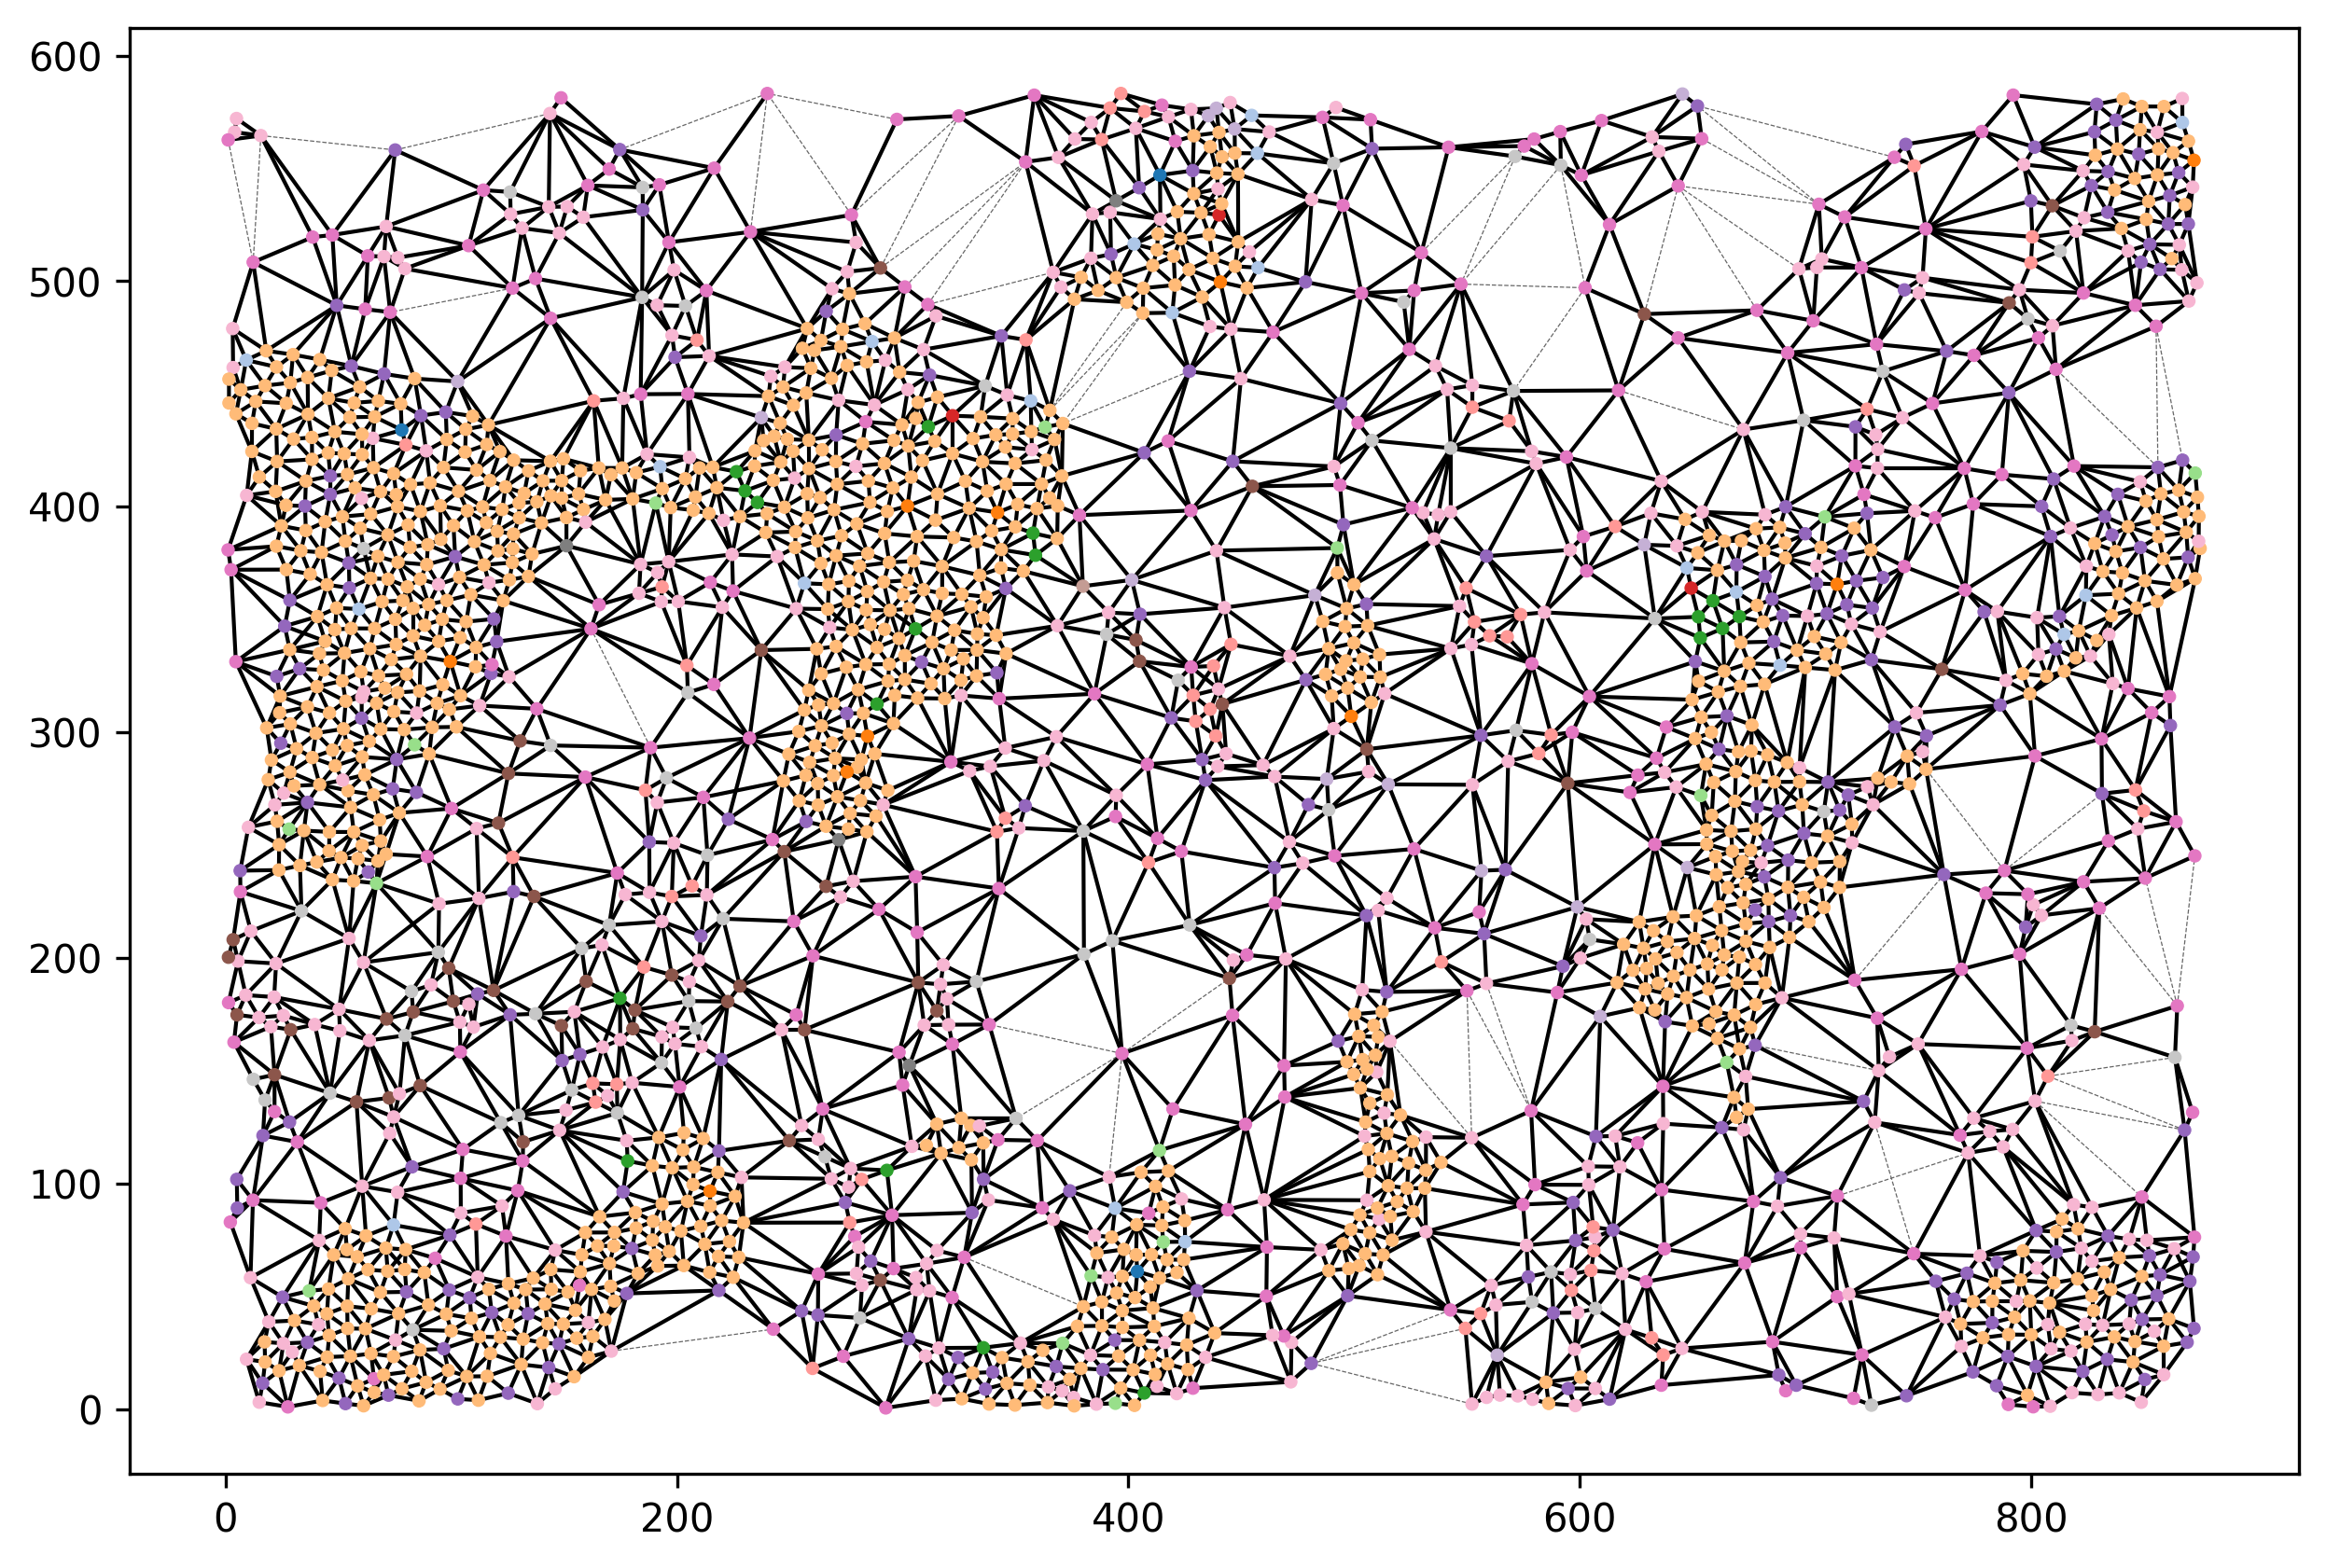

In [49]:
from IPython.display import Image 
pil_img = Image(filename=graph_img_output)
display(pil_img)

<br/><br/><br/><br/>

------------
### Step 2: Construct `CellularGraphDataset`

`CellularGraphDataset` will be the major data container used in model training and evaluation. This object also handles all the featurization, subgraph sampling, and other necessary functionalities for SPACE-GM.

We previously saved all regions as networkx graphs, now we initialize the dataset object using these graph files

In [64]:
dataset_root = f"{parent_path}/graph_and_model"
dataset_kwargs = {
    'transform': [],
    'pre_transform': None,
    'raw_folder_name': 'graph',  # os.path.join(dataset_root, "graph") is the folder where we saved nx graphs
    'processed_folder_name': 'tg_graph',  # processed dataset files will be stored here
    'node_features': ["cell_type", "biomarker_expression", "neighborhood_composition", "center_coord"],  # There are all the cellular features that we want the dataset to compute
    'edge_features': ["edge_type", "distance"],  # edge (cell pair) features
    'subgraph_size': 3,  # indicating we want to sample 3-hop subgraphs from these regions (for training/inference), this is a core parameter for SPACE-GM.
    'subgraph_source': 'on-the-fly',
    'subgraph_allow_distant_edge': True,
    'subgraph_radius_limit': 200.,
}

feature_kwargs = {
    "biomarker_expression_process_method": "linear",
    "biomarker_expression_lower_bound": 0,
    "biomarker_expression_upper_bound": 18,
    "neighborhood_size": 10,
}
dataset_kwargs.update(feature_kwargs)

dataset = spacegm.CellularGraphDataset(dataset_root, **dataset_kwargs)

Processing...
Done!


<br/><br/><br/><br/>

The full cellular graph for each region in the dataset can be accessed using the class method `get_full`:

In [65]:
i = 0
dataset.get_full(i)

Data(x=[3556, 60], edge_index=[2, 20926], edge_attr=[20926, 2], num_nodes=3556, region_id='BaselTMA_SP41_100_X15Y5', component_id=0)

<br/><br/><br/><br/>

And the n-hop (n=3 in this example) subgraph of region `i` around its center node `j` can be accessed using the class method `get_subgraph`: 

In [66]:
i = 0
j = 1234
dataset.get_subgraph(i, j)

Data(x=[39, 60], edge_index=[2, 186], edge_attr=[186, 2], center_node_index=15, original_center_node=1234, num_nodes=39, region_id='BaselTMA_SP41_100_X15Y5', component_id=0)

<br/><br/><br/><br/>

By default, indexing the dataset object will yield an n-hop subgraph around a randomly picked center node (see class method `pick_center`) in the specified region:

In [67]:
dataset[0]

Data(x=[43, 60], edge_index=[2, 212], edge_attr=[212, 2], center_node_index=15, original_center_node=755, num_nodes=43, region_id='BaselTMA_SP41_100_X15Y5', component_id=0)

<br/><br/><br/><br/>

There is also a quick plotting functions for subgraphs: `plot_subgraph`

(-38.85131172839586,
 102.87600308642065,
 145.82770061728274,
 287.55501543209925)

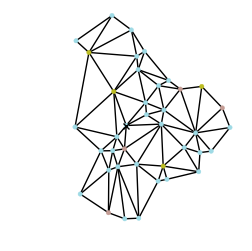

In [68]:
i = 0
j = 1234

plt.figure(figsize=(3, 3))
dataset.plot_subgraph(i, j)
plt.axis('off')

<br/><br/><br/><br/>

During training, due to the high throughput of data streaming, on-the-fly calculation of subgraph might be slow. To speed up data loading, we will save all subgraphs to chunk files first and load them during training/inference.

In [69]:
dataset.save_all_subgraphs_to_chunk()

In [70]:
import time

dataset.clear_cache()
dataset.set_subgraph_source('on-the-fly') # Can also be set through the `subgraph_source` argument
t0 = time.time()
for _ in range(5000):
    d = dataset[0]
t1 = time.time()
print("Sampling 5000 subgraphs on-the-fly took %.2f seconds" % (t1 - t0))

dataset.clear_cache()
dataset.set_subgraph_source('chunk_save')  
t0 = time.time()
for _ in range(5000):
    d = dataset[0]
t1 = time.time()
print("Loading 5000 subgraphs from chunk save took %.2f seconds" % (t1 - t0))


Sampling 5000 subgraphs on-the-fly took 3.45 seconds
Loading 5000 subgraphs from chunk save took 0.71 seconds


<br/><br/><br/><br/>

Transformers will be used to mask features, add node-level and graph-level tasks, etc.

In [71]:
transformers = [
    # `AddCenterCellType` will add `node_y` attribute to the subgraph for node-level prediction task
    # In this task we will mask the cell type of the center cell (replace it by a placeholder cell type)
    # and use its neighborhood to predict the true cell type
    spacegm.AddCenterCellType(dataset),
    # `AddGraphLabel` will add `graph_y` and `graph_w` attributes to the subgraph for graph-level prediction task
    spacegm.AddGraphLabel(graph_label_file, tasks=['ERStatus', 'PRStatus', 'HER2Status']),
    # Transformer `FeatureMask` will zero mask all feature items not included in its argument
    # In this tutorial we perform training/inference using cell types and center cell's size feature
    spacegm.FeatureMask(dataset, use_center_node_features=['cell_type'], use_neighbor_node_features=['cell_type']),
]

dataset.set_transforms([])  # No transformation
d1 = dataset[0]

dataset.set_transforms(transformers)
d2 = dataset[0]

<br/><br/>
`d1.x` has a full feature matrix, while `d2.x` only has the first column (for cell types) populated, except for its center cell, which has an additional feature of size.

(`d1` and `d2` are different subgraphs due to the random sampling)

In [72]:
print("\nFeatures of `d1`")
display(d1.x)
print("\nFeatures of `d2`")
display(d2.x)
print("\nCenter cell feature of `d2`")
display(d2.x[d2.center_node_index])


Features of `d1`


tensor([[2.0000e+01, 6.1495e-03, 0.0000e+00,  ..., 0.0000e+00, 4.6403e+02,
         4.8557e+02],
        [2.1000e+01, 1.4953e-02, 4.5348e-03,  ..., 0.0000e+00, 4.8986e+02,
         4.9493e+02],
        [4.0000e+00, 2.1170e-02, 1.3679e-01,  ..., 0.0000e+00, 5.1306e+02,
         5.1639e+02],
        ...,
        [2.1000e+01, 1.3703e-02, 2.0656e-02,  ..., 0.0000e+00, 5.2252e+02,
         4.3357e+02],
        [4.0000e+00, 1.0510e-02, 5.7850e-02,  ..., 0.0000e+00, 4.9393e+02,
         4.3018e+02],
        [4.0000e+00, 6.1262e-03, 1.1815e-01,  ..., 0.0000e+00, 4.8649e+02,
         4.3130e+02]], dtype=torch.float64)


Features of `d2`


tensor([[4., 0., 0.,  ..., 0., 0., 0.],
        [4., 0., 0.,  ..., 0., 0., 0.],
        [4., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [4., 0., 0.,  ..., 0., 0., 0.],
        [4., 0., 0.,  ..., 0., 0., 0.],
        [4., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)


Center cell feature of `d2`


tensor([27.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.], dtype=torch.float64)

<br/><br/>

Note that d2 has additional attributes: `d2.node_y`, `d2.graph_y`, `d2.graph_w`

In [73]:
display(d1)
display(d2)

Data(x=[57, 60], edge_index=[2, 282], edge_attr=[282, 2], center_node_index=19, original_center_node=598, num_nodes=57, region_id='BaselTMA_SP41_100_X15Y5', component_id=0)

Data(x=[40, 60], edge_index=[2, 194], edge_attr=[194, 2], center_node_index=11, original_center_node=2678, num_nodes=40, region_id='BaselTMA_SP41_100_X15Y5', component_id=0, node_y=[1], graph_y=[1, 3], graph_w=[1, 3])

<br/><br/><br/><br/>

------

### Step 3 Initialize a Graph Neural Network (GNN)

Now we construct a graph neural network for predicting `survival_status`.

The graph neural network will be composed of 3 parts:
1. The backbone GNN with specified number of graph convolutional layers
2. A node task prediction module if there are node-level tasks defined, this module will be constructed based on the node embedding of the center node
3. A graph task prediction module if there are graph-level tasks defined, this module will be constructed based on the graph-pooled embedding of all the nodes

In [74]:
model_kwargs = {
    'num_layer': dataset.subgraph_size,  # same number of layers as number of hops in the subgraphs
    'num_node_type': len(dataset.cell_type_mapping) + 1,  # number of embeddings for different cell types (plus one placeholder cell type)
    'num_feat': dataset[0].x.shape[1] - 1,  # exclude the cell type column
    'emb_dim': 512, 
    'num_node_tasks': len(dataset.cell_type_mapping),  # A multi-class classification task: predicting center cell type
    'num_graph_tasks': 3,  # a binary classification task
    'node_embedding_output': 'last', 
    'drop_ratio': 0.25, 
    'graph_pooling': "max", 
    'gnn_type': 'gin',
}

model = spacegm.GNN_pred(**model_kwargs)
device = 'cpu'

display(model)

GNN_pred(
  (gnn): GNN(
    (x_embedding): Embedding(28, 512)
    (feat_embedding): Linear(in_features=59, out_features=512, bias=True)
    (gnns): ModuleList(
      (0-2): 3 x GINConv()
    )
    (batch_norms): ModuleList(
      (0-2): 3 x BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (graph_pred_module): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=512, out_features=3, bias=True)
  )
  (node_pred_module): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=512, out_features=27, bias=True)
  )
)

<br/><br/><br/><br/>

------

### Step 4 Train the GNN

GNNs in SPACE-GM are trained using n-hop subgraphs, see `data.SubgraphSampler` for details.

In this tutorial we specified one node-level task (predicting center cell type) and one graph-level task (predicting binary survival status), each task will have a specific loss function.


In [75]:
train_kwargs = {
    'batch_size': 64,
    'lr': 0.001,
    'graph_loss_weight': 1.0,  # Weight of graph task loss relative to node task loss
    'num_iterations': 50,  # In this demo we only train for 50 iterations/batches

    # Loss functions
    'node_task_loss_fn': nn.CrossEntropyLoss(),
    'graph_task_loss_fn': spacegm.models.BinaryCrossEntropy(),    

    # Evaluation during training
    'evaluate_fn': [spacegm.train.evaluate_by_sampling_subgraphs, spacegm.train.evaluate_by_full_graph, spacegm.train.save_model_weight],
    'evaluate_freq': 10,  # Evaluate the model every 10 iterations
}

<br/><br/>

On-the-fly evaluation of model performances is included in the training pipeline:

In [76]:
evaluate_kwargs = {
    'node_task_evaluate_fn': spacegm.inference.cell_type_prediction_evaluate_fn,
    'graph_task_evaluate_fn': spacegm.inference.graph_classification_evaluate_fn,
    'full_graph_node_task_evaluate_fn': spacegm.inference.full_graph_cell_type_prediction_evaluate_fn,
    'full_graph_graph_task_evaluate_fn': spacegm.inference.full_graph_graph_classification_evaluate_fn,
    'num_eval_iterations': 10,
    'score_file': os.path.join(model_save_root, 'GIN-example.txt'),
    'model_folder': os.path.join(model_save_root, 'GIN-example'),
}
train_kwargs.update(evaluate_kwargs)

<br/><br/>

Run training:

In [77]:
model = spacegm.train.train_subgraph(
    model, 
    dataset,
    device,
    # train_inds=[0, 1, 2, 3],
    # valid_inds=[0, 1, 2, 3],
    **train_kwargs)

Finished iterations 10
Finished iterations 20
Finished iterations 30
Finished iterations 40


<br/><br/>

Evaluation metrics during training are saved in the specified score file:

In [78]:
with open(evaluate_kwargs['score_file'], 'r') as f:
    for line in f.readlines():
        print(line)

Eval-Subgraph,Train,node-score,0.109,0.167,0.356,0.491,graph-score,0.787,0.746,0.645

Eval-Full-Graph,Train,node-score,0.108,0.153,0.328,0.452,graph-score,0.810,0.749,0.693

Eval-Subgraph,Train,node-score,0.138,0.200,0.377,0.500,graph-score,0.790,0.718,0.632

Eval-Full-Graph,Train,node-score,0.134,0.199,0.365,0.444,graph-score,0.851,0.767,0.686

Eval-Subgraph,Train,node-score,0.226,0.383,0.561,0.683,graph-score,0.768,0.669,0.662

Eval-Full-Graph,Train,node-score,0.235,0.395,0.570,0.665,graph-score,0.847,0.737,0.716

Eval-Subgraph,Train,node-score,0.195,0.267,0.427,0.566,graph-score,0.821,0.725,0.706

Eval-Full-Graph,Train,node-score,0.233,0.325,0.429,0.622,graph-score,0.863,0.783,0.755



<br/><br/>

Intermediate model weights are saved in the specified model folder:

In [79]:
print(os.listdir(evaluate_kwargs['model_folder']))

['model_save_2.pt', 'model_save_3.pt', 'model_save_0.pt', 'model_save_1.pt']


<br/><br/><br/><br/>

------

### Step 5 Evaluate the GNN

As GNNs are trained using subgraphs, there are two ways for evaluation (especially for graph-level tasks):

- Sample subgraphs and calculate metrics by treating each subgraph as an independent data point;
- Iterate over all the subgraphs (cells) of each region and calculate metrics, for graph-level tasks treat the aggregated (average) prediction from a region as an independent data point;

This is also reflected in the on-the-fly evaluation above: `spacegm.train.evaluate_by_sampling_subgraphs` and `spacegm.train.evaluate_by_full_graph`.

Here we demonstrate the two types of evaluation:

In [81]:
# Evaluation by iterating over the full graph
node_preds, graph_preds = spacegm.inference.collect_predict_for_all_nodes(
    model, dataset, device, print_progress=True)

# Aggregated (average) predictions of each region
for i, pred in graph_preds.items():
    region_id = dataset[i].region_id
    predicted_prob = 1 / (1 + np.exp(-np.array(pred)))  # Sigmoid
    avg_pred = np.mean(predicted_prob)
    print("On region %s, average prediction: %.3f" % (region_id, avg_pred))

spacegm.inference.full_graph_graph_classification_evaluate_fn(dataset, graph_preds, print_res=True)

predict on 0
predict on 1
predict on 2
predict on 3
predict on 4
predict on 5
predict on 6
predict on 7
predict on 8
predict on 9
predict on 10
predict on 11
predict on 12
predict on 13
predict on 14
predict on 15
predict on 16
predict on 17
predict on 18
predict on 19
predict on 20
predict on 21
predict on 22
predict on 23
predict on 24
predict on 25
predict on 26
predict on 27
predict on 28
predict on 29
predict on 30
predict on 31
predict on 32
predict on 33
predict on 34
predict on 35
predict on 36
predict on 37
predict on 38
predict on 39
predict on 40
predict on 41
predict on 42
predict on 43
predict on 44
predict on 45
predict on 46
predict on 47
predict on 48
predict on 49
predict on 50
predict on 51
predict on 52
predict on 53
predict on 54
predict on 55
predict on 56
predict on 57
predict on 58
predict on 59
predict on 60
predict on 61
predict on 62
predict on 63
predict on 64
predict on 65
predict on 66
predict on 67
predict on 68
predict on 69
predict on 70
predict on 71
pr

[0.8638903326403325, 0.7800254777070063, 0.7392271566284914]

In [83]:
# Evaluation by sampling subgraphs
node_preds, node_labels, graph_preds, graph_ys, graph_ws = spacegm.inference.collect_predict_by_random_sample(
    model, dataset, device, num_eval_iterations=50)
spacegm.inference.graph_classification_evaluate_fn(graph_preds, graph_ys, graph_ws)

GRAPH [0.8096582038107504, 0.7376263066184885, 0.7091306922874441]


[0.8096582038107504, 0.7376263066184885, 0.7091306922874441]